# Quantization for CMSIS-NN

Date: Nov 11, 2018

Quantize weights and biases from Keras CNN model.

Reference: https://community.arm.com/processors/b/blog/posts/deploying-convolutional-neural-network-on-cortex-m-with-cmsis-nn

In [19]:
#!/usr/bin/env python3

from keras import models
import serial
import numpy as np
import pandas as pd
import yaml
import time
import matplotlib.pyplot as plt
%matplotlib inline


DATA_FOLDER = '../oscilloscope/data_music/'

# MODEL = './cnn_for_aed_20181107185253.h5'
# MODEL = './cnn_for_aed_20181110221837.h5'
MODEL = '../tensorflow/cnn_for_aed_20181111211558.h5'

with open(DATA_FOLDER+'class_labels.yaml', 'r') as f:
    class_labels = yaml.load(f)

#print(class_labels)

model = models.load_model(MODEL)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 288)               0         
__________

In [133]:
conv2d_1 = model.layers[2].get_weights()
bias = conv2d_1[1]
filter_ = conv2d_1[0]
print(bias)
print(filter_)
print(filter_.shape)

[ 0.01777769 -0.00845764  0.01150828 -0.00247425  0.011081    0.10478817
  0.02867063  0.02715485]
[[[[ 0.09744884 -0.19868487 -0.18458456  0.04582829  0.21442795
     0.2023839   0.14018635 -0.09801631]
   [-0.24325387 -0.14401503  0.3551884  -0.07870063  0.19965763
     0.18095589  0.02600593  0.16335927]
   [ 0.0742927   0.06740445 -0.06689061 -0.29224032 -0.1345016
     0.0065839  -0.09972803 -0.02478449]
   [-0.03027753 -0.16554491  0.2837726   0.0264269  -0.05352686
    -0.14239061 -0.26054105  0.04927359]]

  [[-0.26390323 -0.10916133 -0.07361007  0.14303419 -0.32332757
     0.28230947  0.1431566  -0.15563321]
   [ 0.00396006  0.06658679  0.21314111 -0.09533431 -0.14499108
    -0.21046185 -0.13214564  0.02655707]
   [-0.12477488 -0.19117877  0.06241727  0.15594262 -0.00347502
     0.18378264  0.12566459 -0.06209244]
   [-0.02150992  0.16163547  0.00964544 -0.07880041  0.03355636
     0.12364098 -0.10273905 -0.12907493]]

  [[-0.06200593 -0.06411245  0.32113522  0.16929474 -0.261

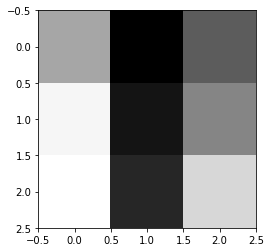

In [134]:
plt.imshow(filter_[:,:,0,0], cmap=plt.get_cmap('gray'))

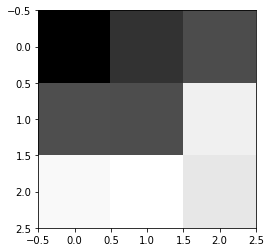

In [135]:
plt.imshow(filter_[:,:,0,1], cmap=plt.get_cmap('gray'))

In [136]:
# Q7
(filter_*2**7).astype(int)

array([[[[ 12, -25, -23,   5,  27,  25,  17, -12],
         [-31, -18,  45, -10,  25,  23,   3,  20],
         [  9,   8,  -8, -37, -17,   0, -12,  -3],
         [ -3, -21,  36,   3,  -6, -18, -33,   6]],

        [[-33, -13,  -9,  18, -41,  36,  18, -19],
         [  0,   8,  27, -12, -18, -26, -16,   3],
         [-15, -24,   7,  19,   0,  23,  16,  -7],
         [ -2,  20,   1, -10,   4,  15, -13, -16]],

        [[ -7,  -8,  41,  21, -33,  27, -26,   0],
         [ 12, -25,   5,  14,  -8,  -6,  21,   5],
         [ 25,  29, -14, -16,  -8,   8,  12,  17],
         [ 18,   8, -25,  21,  -7,  17, -23,   5]]],


       [[[ 34,  -7, -11, -23,  34,  -8,  31,   4],
         [ 24,  23,  28,   5,   2,   2,  34,  20],
         [ 17, -25, -16, -34,  28,   2,   9, -15],
         [-40,   0,  34,  12,  17,  23,   2,   5]],

        [[-28,  -7,   0, -21,  21, -16, -24,  -9],
         [ -9,  -5, -20,  17,  28,  -1,  29,   7],
         [-16, -35,  27, -23,  -4,   6,  29, -28],
         [ 26,   6,  

In [141]:
# Q7 flatten
def flatten_filter_q7(filter_, size, num_filters1, num_filters2):
    filter_q7 = (filter_*2**7).astype(np.int8)
    return filter_q7.reshape(size*size,num_filters1*num_filters2).T.reshape(size*size*num_filters1*num_filters2)

def flatten_dense_q7(dense):
    w, c = dense.shape
    dense = dense.reshape(w*c)
    return (dense*2**7).astype(np.int8)

def bias_q7(bias):
    return (bias*2**7).astype(np.int8)

def print_define(cname, list_):
    print('#define{} {{ {} }}'.format(cname, str(list_)[1:-1]))
    print()

In [142]:
flatten_filter_q7(filter_, 3, 4, 8), bias_q7(bias)

(array([ 12, -33,  -7,  34, -28,   3,  37, -23,  26, -25, -13,  -8,  -7,
         -7,  28,  30,  32,  26, -23,  -9,  41, -11,   0,  18,   5,  10,
         36,   5,  18,  21, -23, -21, -14,  18, -19,  32,  27, -41, -33,
         34,  21,  -1,  34, -26,  27,  25,  36,  27,  -8, -16, -12,   8,
        -14,   7,  17,  18, -26,  31, -24,  17,   9,   0, -18, -12, -19,
          0,   4,  -9,   7, -26,  -9,  -4, -31,   0,  12,  24,  -9,   9,
        -36,  -8,  -4, -18,   8, -25,  23,  -5, -19,   7, -13,  11,  45,
         27,   5,  28, -20, -21,  11,  -1, -27, -10, -12,  14,   5,  17,
         31,  14,  19,  20,  25, -18,  -8,   2,  28,   8,  -1,  23, -18,
         23, -26,  -6,   2,  -1, -17,  -2,   6, -11,   3, -16,  21,  34,
         29, -24, -29,  20,  16,  20,   3,   5,  20,   7,  -5,  19,  -4,
         31,   9, -15,  25,  17, -16, -18,  29, -33,  17,   8, -24,  29,
        -25, -35, -13,  21, -25,  27,  -8,   7, -14, -16,  27,  40, -13,
         11,   6, -37,  19, -16, -34, -23,  12, -11

## Generating a header file for CMSIS-NN

In [143]:
conv2d_1 = model.layers[0].get_weights()
conv2d_2 = model.layers[2].get_weights()
conv2d_3 = model.layers[4].get_weights()
dense_1 = model.layers[8].get_weights()

print_define('CONV1_WT',  flatten_filter_q7(conv2d_1[0], 3, 1, 4).tolist())
print_define('CONV1_BIAS',  bias_q7(conv2d_1[1]).tolist())

print_define('CONV2_WT',  flatten_filter_q7(conv2d_2[0], 3, 4, 8).tolist())
print_define('CONV2_BIAS',  bias_q7(conv2d_2[1]).tolist())

print_define('CONV3_WT',  flatten_filter_q7(conv2d_3[0], 3, 8, 16).tolist())
print_define('CONV3_BIAS',  bias_q7(conv2d_3[1]).tolist())

print_define('IP1_WT',  flatten_dense_q7(dense_1[0]).tolist())
print_define('IP1_BIAS',  bias_q7(dense_1[1]).tolist())

#defineCONV1_WT { 61, 58, -30, 52, 38, 2, 30, 27, 41, -49, -27, -25, 29, -46, 30, -34, -12, 27, 4, 21, 53, 48, 68, -16, 55, 42, 5, -6, -39, 46, -34, -48, 12, -59, 4, 50 }

#defineCONV1_BIAS { 30, 4, 7, 0 }

#defineCONV2_WT { 12, -33, -7, 34, -28, 3, 37, -23, 26, -25, -13, -8, -7, -7, 28, 30, 32, 26, -23, -9, 41, -11, 0, 18, 5, 10, 36, 5, 18, 21, -23, -21, -14, 18, -19, 32, 27, -41, -33, 34, 21, -1, 34, -26, 27, 25, 36, 27, -8, -16, -12, 8, -14, 7, 17, 18, -26, 31, -24, 17, 9, 0, -18, -12, -19, 0, 4, -9, 7, -26, -9, -4, -31, 0, 12, 24, -9, 9, -36, -8, -4, -18, 8, -25, 23, -5, -19, 7, -13, 11, 45, 27, 5, 28, -20, -21, 11, -1, -27, -10, -12, 14, 5, 17, 31, 14, 19, 20, 25, -18, -8, 2, 28, 8, -1, 23, -18, 23, -26, -6, 2, -1, -17, -2, 6, -11, 3, -16, 21, 34, 29, -24, -29, 20, 16, 20, 3, 5, 20, 7, -5, 19, -4, 31, 9, -15, 25, 17, -16, -18, 29, -33, 17, 8, -24, 29, -25, -35, -13, 21, -25, 27, -8, 7, -14, -16, 27, 40, -13, 11, 6, -37, 19, -16, -34, -23, 12, -11, -28, 16, -17, 0, -8, 28, -4, 26, 